In [2]:
import pandas as pd
import numpy as np
import pyarrow.feather as feather


In [3]:
l_paths_df = pd.read_feather('Data/dataframes/length_filt_finished_paths.feather')
t_paths_df = pd.read_feather('Data/dataframes/time_filt_finished_paths.feather')

In [4]:
df = t_paths_df[['durationInSec', 'simplified_path', 'simplified_path_length', 'full_path_length', 'distance']].copy()

df['weight'] = df['distance'] / df['simplified_path_length']
df['speed'] = df['full_path_length'] / df['durationInSec']


,durationInSec,simplified_path,simplified_path_length,full_path_length,distance,weight,speed
21240,664,"[Politics_of_the_United_Kingdom, Northern_Irel...",14,17,5.0,0.357143,0.025602
21469,655,"[Ulawun, Volcano, Sun, Planet, Earth, Norse_my...",7,8,5.0,0.714286,0.012214
21399,648,"[The_Absent-Minded_Beggar, Arthur_Sullivan, Lo...",11,11,5.0,0.454545,0.016975
21432,642,"[John_W._Campbell, Nobel_Peace_Prize, Presiden...",8,10,5.0,0.625000,0.015576
21303,586,"[Colombia, Pacific_Ocean, Earth, Oxygen, Plant...",9,13,5.0,0.555556,0.022184
21309,578,"[Natural_selection, Sociocultural_evolution, C...",10,10,5.0,0.500000,0.017301
21358,576,"[Eukaryote, Organism, Human, Conflict, War, In...",10,15,5.0,0.500000,0.026042
21409,573,"[Enzyme_kinetics, DNA, Animal, Mammal, Austral...",9,10,5.0,0.555556,0.017452
21274,566,"[Animal, Human, Monarchy, British_monarchy, St...",5,12,5.0,1.000000,0.021201
21374,535,"[Norman_Borlaug, United_States, Space_Shuttle_...",9,11,5.0,0.555556,0.020561


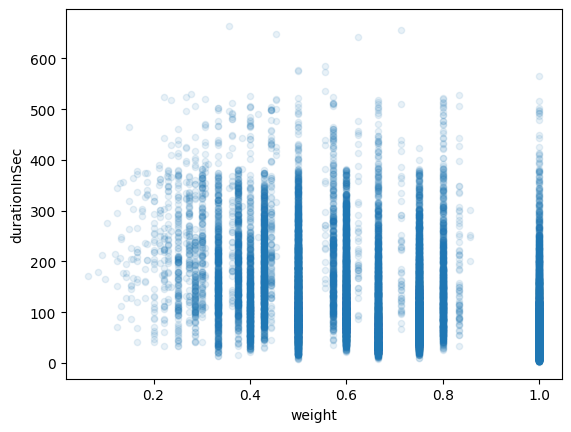

In [5]:
df.plot.scatter(x='weight', y='durationInSec', alpha=0.1)

df.sort_values('durationInSec', ascending=False).head(10)

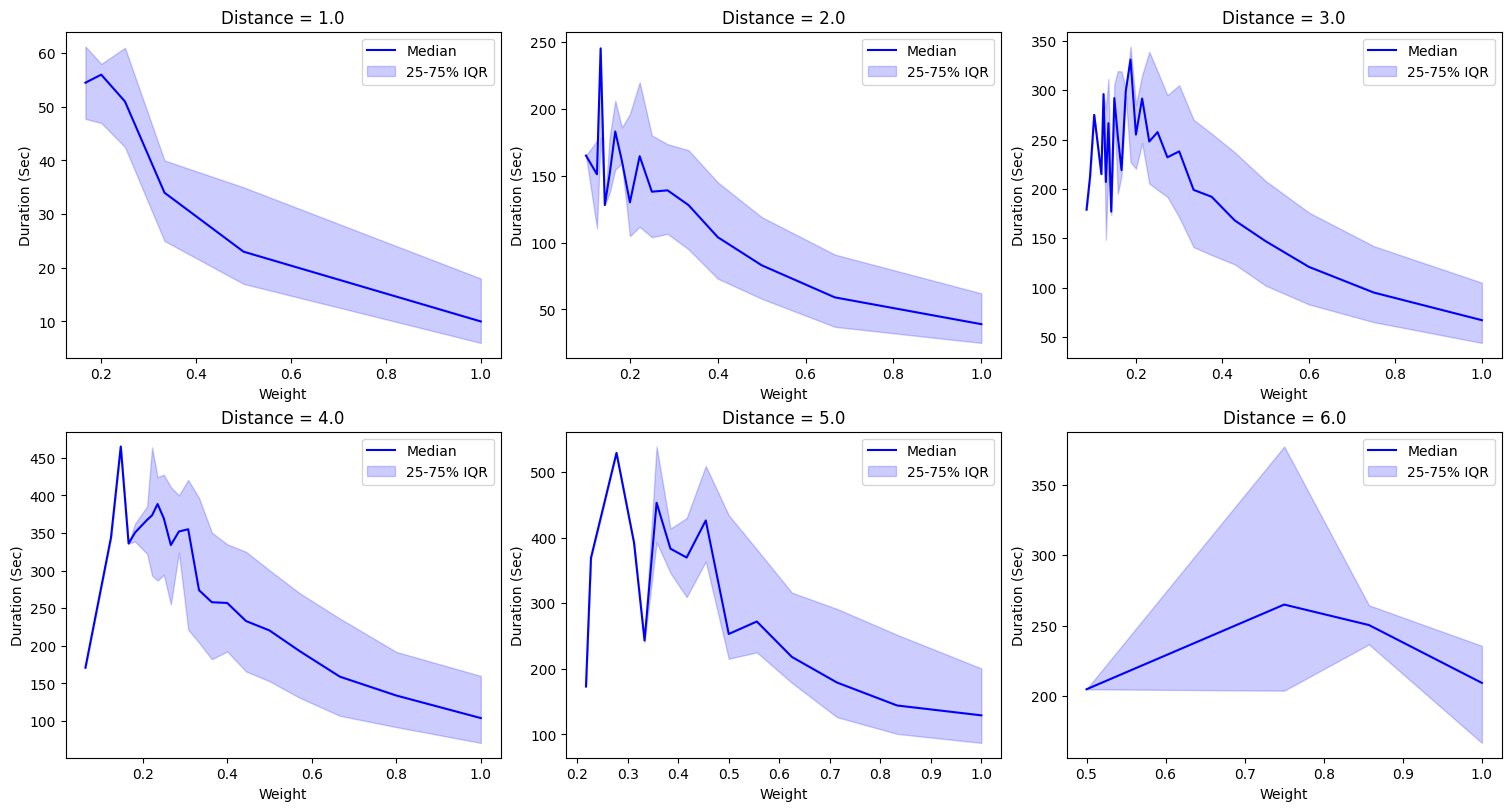

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Group by 'distance' and 'weight', and calculate median and IQR
grouped = df.groupby(['distance', 'weight'])['durationInSec'].agg(
    median='median',
    q25=lambda x: np.percentile(x, 25),
    q75=lambda x: np.percentile(x, 75)
).reset_index()

# Get unique distances and determine the layout of subplots
unique_distances = np.sort(df['distance'].unique())
n_distances = len(unique_distances)
n_cols = 3  # Number of columns in the grid
n_rows = (n_distances + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each distance and create a subplot
for i, distance in enumerate(unique_distances):
    # Filter data for the current distance
    distance_data = grouped[grouped['distance'] == distance]
    
    # Plot median as a line and IQR as a shaded area
    axes[i].plot(distance_data['weight'], distance_data['median'], label='Median', color='blue')
    axes[i].fill_between(
        distance_data['weight'],
        distance_data['q25'],
        distance_data['q75'],
        alpha=0.2,
        color='blue',
        label='25-75% IQR'
    )
    axes[i].set_title(f'Distance = {distance}')
    axes[i].set_xlabel('Weight')
    axes[i].set_ylabel('Duration (Sec)')
    axes[i].legend()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show the plot
plt.show()




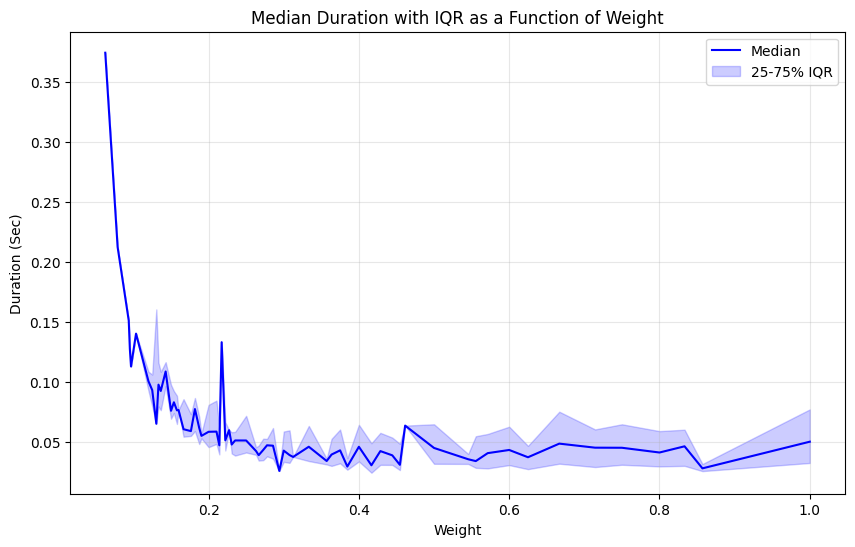

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Group by 'weight' and calculate the median and IQR
grouped = df.groupby('weight')['durationInSec'].agg(
    median='median',
    q25=lambda x: np.percentile(x, 25),
    q75=lambda x: np.percentile(x, 75)
).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the median as a line
plt.plot(grouped['weight'], grouped['median'], label='Median', color='blue')

# Plot the IQR as a shaded area
plt.fill_between(
    grouped['weight'],
    grouped['q25'],
    grouped['q75'],
    color='blue',
    alpha=0.2,
    label='25-75% IQR'
)

# Add labels, legend, and title
plt.xlabel('Weight')
plt.ylabel('Duration (Sec)')
plt.title('Median Duration with IQR as a Function of Weight')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [45]:
print(np.sort(df['distance'].unique()))

[1. 2. 3. 4. 5. 6.]


## Adjust path duration for distance

In [7]:
grouped_by_distance = t_paths_df.groupby('distance')['durationInSec'].agg(median_time = 'median',
                                                    mean = 'mean',
                                                    samples = 'count').reset_index()
grouped_by_distance.set_index('distance', inplace=True)
grouped_by_distance['scaling_factor'] = grouped_by_distance['median_time'].loc[3.0] / grouped_by_distance['median_time']
#grouped_by_distance['scaling_factor'] = grouped_by_distance['median_time'].loc[2] / grouped_by_distance['median_time']

grouped_by_distance

,median_time,mean,samples,scaling_factor
distance,,,,
1.0,14.0,19.528701,331,7.857143
2.0,66.0,79.818074,5079,1.666667
3.0,110.0,130.480215,12282,1.000000
4.0,156.0,183.685495,3523,0.705128
5.0,206.5,237.981343,268,0.532688
6.0,233.0,247.600000,15,0.472103


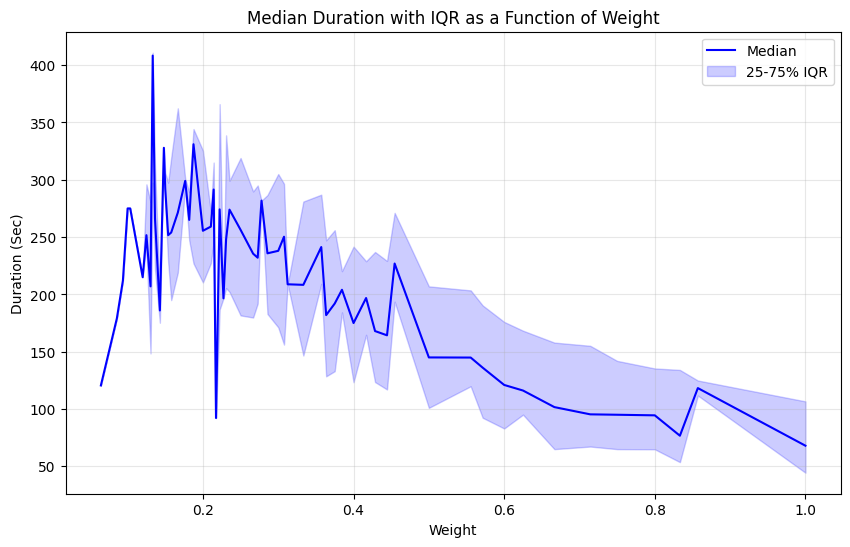

In [26]:
df = t_paths_df[['durationInSec', 'simplified_path', 'simplified_path_length', 'full_path_length', 'distance']].copy()

df['weight'] = df['distance'] / df['simplified_path_length']
df['speed'] = df['full_path_length'] / df['durationInSec']

df['scaled_duration'] = df['durationInSec'] * df['distance'].map(grouped_by_distance.set_index('distance')['scaling_factor'])


# Group by 'weight' and calculate the median and IQR
grouped = df.groupby('weight')['scaled_duration'].agg(
    median='median',
    q25=lambda x: np.percentile(x, 25),
    q75=lambda x: np.percentile(x, 75)
).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the median as a line
plt.plot(grouped['weight'], grouped['median'], label='Median', color='blue')

# Plot the IQR as a shaded area
plt.fill_between(
    grouped['weight'],
    grouped['q25'],
    grouped['q75'],
    color='blue',
    alpha=0.2,
    label='25-75% IQR'
)

# Add labels, legend, and title
plt.xlabel('Weight')
plt.ylabel('Duration (Sec)')
plt.title('Median Duration with IQR as a Function of Weight')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


write down thoughts...

for path scoring it makes sense to adjust for distance, but for article scoring it makes sense to adjust for simplified path length.
actually no.
but how to take into the weighting only the articles that contribute in the direct path
=> if there are detour articles, do a first adjustement: adj_duration = duration in time simplified path length / full path length
then do the adjustemnt for distance

In [5]:
from src.utils.score_utils import *
from 

time_scores = calc_avg_article_adjusted_time(t_paths_df, scaling='standard', consider_start=True)
weight_scores = calculate_avg_article_weights(l_paths_df, scaling='standard', consider_start=True)

In [24]:
time_scores.sort_values('avg_adj_time', ascending=True)

,n_appearances,avg_adj_time,standard
article,,,
Great_Lakes,45.0,95.367509,3.001223
Bat,31.0,99.393109,2.753804
Harry_Potter,31.0,103.247544,2.516904
Antarctica,89.0,105.591190,2.372860
Whale,71.0,105.638103,2.369977
...,...,...,...
Yellowstone_National_Park,41.0,188.067446,-2.696252
Steam_engine,36.0,190.349346,-2.836501
Aircraft,37.0,193.145855,-3.008378


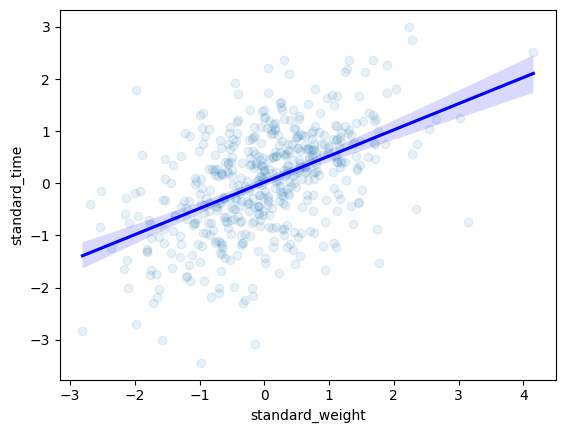

In [25]:
merged = pd.merge(time_scores, weight_scores, on='article', suffixes=('_time', '_weight'))

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged' is your DataFrame with 'avg_adj_time' and 'weighted_avg' columns
sns.regplot(x='standard_weight', y='standard_time', data=merged, scatter_kws={'alpha': 0.1}, line_kws={'color': 'blue'})

plt.show()


In [21]:
merged

,n_appearances_time,avg_adj_time,standard_time,n_appearances_weight,weighted_avg,standard_weight
article,,,,,,
Theatre,46.0,161.563526,-1.182339,34.0,0.605392,-0.271585
India,495.0,127.638185,1.010181,492.0,0.667645,1.188086
Indian_Ocean,137.0,118.748208,1.584721,143.0,0.626832,0.231114
Africa,1111.0,126.712383,1.070014,1109.0,0.668338,1.204332
Brain,93.0,158.096856,-0.958296,84.0,0.671816,1.285889
...,...,...,...,...,...,...
Benjamin_Franklin,34.0,136.226140,0.455160,35.0,0.609324,-0.179397
Finland,44.0,130.369988,0.833631,46.0,0.621708,0.110975
Tibet,30.0,151.864047,-0.555483,31.0,0.632168,0.356253


.  
.  
.  
.  
.  
.  
.  
.  
.  


NameError: name 'calculate_sum_article_cweights' is not defined

In [6]:
cweight_df.sort_values('weighted_sum', ascending=False)

,n_appearances,weighted_sum,standard
article,,,
United_States,3649.0,206.997688,20.992510
United_Kingdom,1765.0,38.412771,3.955199
Africa,1109.0,37.343073,3.847094
World_War_II,817.0,28.582474,2.961742
Europe,1761.0,26.830127,2.784648
...,...,...,...
Earth,932.0,-17.146774,-1.659689
Christianity,346.0,-17.344821,-1.679703
Great_Britain,275.0,-17.617683,-1.707279


In [7]:
avg_diff_df.sort_values(by='avg_diff', ascending=True)

,n_appearances,avg_diff,standard
article,,,
Mercury_(element),31.0,1.193548,3.179995
Cricket,45.0,1.333333,2.805062
Harry_Potter,40.0,1.425000,2.559193
Baseball,37.0,1.486486,2.394274
"September_11,_2001_attacks",52.0,1.500000,2.358028
...,...,...,...
Tropics,44.0,3.386364,-2.701589
Health,35.0,3.428571,-2.814799
Permian,31.0,3.548387,-3.136169


In [11]:
weight_scores.sort_values('weighted_avg', ascending=False)

,n_appearances,weighted_avg,standard
article,,,
Mercury_(element),31.0,0.761674,3.392847
Amtrak,39.0,0.757387,3.292321
Harry_Potter,40.0,0.753869,3.209832
Cricket,45.0,0.752363,3.174526
Baseball,37.0,0.738160,2.841484
...,...,...,...
Greenhouse_effect,37.0,0.515845,-2.371252
Henry_VIII_of_England,57.0,0.510300,-2.501268
Tropics,44.0,0.504491,-2.637461


In [12]:
def get_article_paths(article_name, paths_df):
    return paths_df[paths_df['simplified_path'].apply(lambda x: article_name in x[:-1])]

In [13]:
get_article_paths('Mercury_(element)', l_paths_df).sort_values('durationInSec', ascending=True)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
17007,17401b86137918e8,1250380834,27,Sodium_hydroxide;Mercury_(element);Ununbium,1.0,True,None,Sodium_hydroxide,Ununbium,34934,"[Sodium_hydroxide, Mercury_(element), Ununbium]","[Sodium_hydroxide, Mercury_(element), Ununbium]",2.0,2,2
14258,6ee670a118859533,1370972333,33,List_of_elements_by_name;Mercury_(element);Mer...,1.0,True,None,List_of_elements_by_name,Mercury_(planet),23096,"[List_of_elements_by_name, Mercury_(element), ...","[List_of_elements_by_name, Mercury_(element), ...",2.0,2,2
19932,41d16b7848a21301,1304308851,37,Politics_of_the_United_Kingdom;Pollution;Mercu...,NaN,True,None,Politics_of_the_United_Kingdom,Ytterbium,30560,"[Politics_of_the_United_Kingdom, Pollution, Me...","[Politics_of_the_United_Kingdom, Pollution, Me...",4.0,4,4
12148,321e4b101c5b58ff,1219106372,41,Franz_Schubert;Mercury_(element);Ancient_Greec...,2.0,True,None,Franz_Schubert,Demosthenes,15046,"[Franz_Schubert, Mercury_(element), Ancient_Gr...","[Franz_Schubert, Mercury_(element), Ancient_Gr...",3.0,3,3
18681,4bd3e69230e996b0,1222902659,43,Cookiecutter_shark;Tuna;Mercury_(element);Alum...,1.0,True,None,Cookiecutter_shark,Aluminium_chloride,10029,"[Cookiecutter_shark, Tuna, Mercury_(element), ...","[Cookiecutter_shark, Tuna, Mercury_(element), ...",4.0,4,4
2928,68a6c17d2ae6173e,1258104274,45,Albinism;Ultraviolet;Mercury_(element);Periodi...,1.0,True,None,Albinism,Palladium,1554,"[Albinism, Ultraviolet, Mercury_(element), Per...","[Albinism, Ultraviolet, Mercury_(element), Per...",3.0,4,4
7102,0889d30c5ea12e30,1249704474,47,Wake_Island;Mercury_(element);Periodic_table;U...,NaN,True,None,Wake_Island,Ununquadium,40823,"[Wake_Island, Mercury_(element), Periodic_tabl...","[Wake_Island, Mercury_(element), Periodic_tabl...",3.0,3,3
19067,1435204c44915446,1327955940,55,Beeching_Axe;Pollution;Mercury_(element);Chemi...,NaN,True,None,Beeching_Axe,Lanthanum,5097,"[Beeching_Axe, Pollution, Mercury_(element), C...","[Beeching_Axe, Pollution, Mercury_(element), C...",4.0,6,5
16053,655c6da019eed54f,1250396032,59,Michael_Faraday;Mercury_(element);European_Uni...,1.0,True,None,Michael_Faraday,Human,25316,"[Michael_Faraday, Mercury_(element), European_...","[Michael_Faraday, Mercury_(element), Medicine,...",2.0,4,3
8710,7442b91b3646a24a,1298762312,73,Tooth_development;Calcium;Chemical_element;<;P...,2.0,True,None,Tooth_development,Mercury_(planet),38664,"[Tooth_development, Calcium, Chemical_element,...","[Tooth_development, Calcium, Periodic_table, M...",3.0,5,4
